### Data Source：Delivery and customer feedback data for 6 products sold by a company
### Problems to Solve：
##### 1、Are there delivery service issues?
##### 2、Are there untapped sales regions?
##### 3、Are there product quality issues?

### Key Findings：
##### 1、Product 4 → Northwest，Product 2 → MalaysiaTwo routes have significant issues，urgently need to improve delivery time
##### 2、Product 2 has significant market potential in East China，suitable for increased investment，alsoProduct 2 has long delivery time in Northwest，high rejection rate，from a cost perspective，should reduce investment
##### 3、Products 1, 2, 4 have quality issues，recommend expanding inspection scope，increase quality control

### Analysis Process
#### 1、Data Cleaning
##### ① duplicates、missing values、format adjustment
##### ② outlier handling（for example：sales amount equals0of，std of quantity and sales amount are within mean8times or more）
#### 2、Data Preparation
##### for example：add auxiliary column：month
#### 3、Data Analysis & Visualization

In [31]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
plt.rcParams['font.sans-serif'] = 'DejaVu Sans' ## set display

## 1、Data Cleaning
① duplicates、missing values、format adjustment

In [32]:
data = pd.read_csv('data_logistics.csv',encoding='gbk')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1161 entries, 0 to 1160
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   order_id     1159 non-null   object 
 1   order line     1161 non-null   int64  
 2   salestime    1161 non-null   object 
 3   delivery time    1161 non-null   object 
 4   productdelivery_status  1159 non-null   object 
 5   product      1161 non-null   object 
 6   productcustomer_feedback  1161 non-null   object 
 7   salesregion    1161 non-null   object 
 8   countvolume      1157 non-null   float64
 9   sales_amount    1161 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 90.8+ KB


#### viainfo()can see that，including10columndata，name，datavolume，format etc，can conclude：
#### 1.order_id，delivery status，countvolume：existinmissing values，but volume is small，can be deleted
#### 2.order line，foranalysisinsignificant，consider deleting
#### 3.sales_amountformatnotfor（0000CNY|CNY，commaQuestion）,datatype needs to convert toint|float

In [33]:
#deleteduplicate records
data.drop_duplicates(keep='first',inplace=True)
#deletemissing values（na,delete pendingnaofentire rowdata,axis=0,how='any'default value）
data.dropna(axis=0,how='any',inplace=True)
#deleteorder line(rerun will cause error，because the1time alreadydeleteorder linethis1column)
data.drop(columns=['order line'],inplace=True,axis=1)
print(data.info())
#update index(drop=True:change originalofindexindexcolumndelete，resetindex)
data.reset_index(drop=True,inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1146 entries, 0 to 1160
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   order_id     1146 non-null   object 
 1   salestime    1146 non-null   object 
 2   delivery time    1146 non-null   object 
 3   productdelivery_status  1146 non-null   object 
 4   product      1146 non-null   object 
 5   productcustomer_feedback  1146 non-null   object 
 6   salesregion    1146 non-null   object 
 7   countvolume      1146 non-null   float64
 8   sales_amount    1146 non-null   object 
dtypes: float64(1), object(8)
memory usage: 89.5+ KB
None


In [34]:
#extractsales_amountcolumn，for each1dataperformclean
#write custom filterfunction：deletecomma，convert tofloat，if is0000CNYthen*10000，nothen，deleteCNY

In [35]:
def data_deal(number):
    if number.find('0000CNY')!= -1:#find with0000CNYof，extract number，remove comma，convert tofloat，*10000
        number_new = float(number[:number.find('0000CNY')].replace(',',''))*10000
        pass
    else: #find withCNYof，deleteCNY，deletecomma，convert tofloat
        number_new = float(number.replace('CNY','').replace(',',''))
        pass
    return number_new
data['sales_amount'] = data['sales_amount'].map(data_deal)
data

,order_id,salestime,delivery time,productdelivery_status,product,productcustomer_feedback,salesregion,countvolume,sales_amount
0,P096311,2016-7-30,2016-9-30,late,product3,quality_ok,North_China,2.0,105275.0
1,P096826,2016-8-30,2016-10-30,on_time,product3,quality_ok,North_China,10.0,11500000.0
2,P097435,2016-7-30,2016-9-30,on_time,product1,repair,South_China,2.0,685877.0
3,P097446,2016-11-26,2017-1-26,late,product3,quality_ok,North_China,15.0,12958.0
4,P097446,2016-11-26,2017-1-26,late,product3,rejected,North_China,15.0,3239.0
...,...,...,...,...,...,...,...,...,...
1141,P299901,2016-12-15,2017-3-15,on_time,product6,quality_ok,Malaysia,2.0,20041.0
1142,P302956,2016-12-22,2017-3-22,on_time,product2,rejected,East_China,20.0,7944.0
1143,P303801,2016-12-15,2017-3-15,on_time,product2,quality_ok,East_China,1.0,19408.0
1144,P307276,2016-12-22,2017-3-22,on_time,product6,quality_ok,Malaysia,1.0,3218.0


#### ② outlier handling

In [38]:
print(data.describe())

                 countvolume          sales_amount
count   1146.000000  1.146000e+03
mean      76.069372  1.223488e+05
std      589.416486  1.114599e+06
min        1.000000  0.000000e+00
25%        1.000000  2.941500e+03
50%        1.000000  9.476500e+03
75%        4.000000  3.576775e+04
max    11500.000000  3.270000e+07


#### 1.sales amount is0ofsituation，delete
#### 2.cause seriousofdataleft-skewed（e-commerceof2/8rule is normal。）

In [40]:
data = data[data['sales_amount']!=0]
data

,order_id,salestime,delivery time,productdelivery_status,product,productcustomer_feedback,salesregion,countvolume,sales_amount
0,P096311,2016-7-30,2016-9-30,late,product3,quality_ok,North_China,2.0,105275.0
1,P096826,2016-8-30,2016-10-30,on_time,product3,quality_ok,North_China,10.0,11500000.0
2,P097435,2016-7-30,2016-9-30,on_time,product1,repair,South_China,2.0,685877.0
3,P097446,2016-11-26,2017-1-26,late,product3,quality_ok,North_China,15.0,12958.0
4,P097446,2016-11-26,2017-1-26,late,product3,rejected,North_China,15.0,3239.0
...,...,...,...,...,...,...,...,...,...
1141,P299901,2016-12-15,2017-3-15,on_time,product6,quality_ok,Malaysia,2.0,20041.0
1142,P302956,2016-12-22,2017-3-22,on_time,product2,rejected,East_China,20.0,7944.0
1143,P303801,2016-12-15,2017-3-15,on_time,product2,quality_ok,East_China,1.0,19408.0
1144,P307276,2016-12-22,2017-3-22,on_time,product6,quality_ok,Malaysia,1.0,3218.0


### 2、Data Preparation

In [45]:
data['salestime'] = pd.to_datetime(data['salestime'])
data['month'] = data['salestime'].apply(lambda x:x.month)
data

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,order_id,salestime,delivery time,productdelivery_status,product,productcustomer_feedback,salesregion,countvolume,sales_amount,month
0,P096311,2016-07-30,2016-9-30,late,product3,quality_ok,North_China,2.0,105275.0,7
1,P096826,2016-08-30,2016-10-30,on_time,product3,quality_ok,North_China,10.0,11500000.0,8
2,P097435,2016-07-30,2016-9-30,on_time,product1,repair,South_China,2.0,685877.0,7
3,P097446,2016-11-26,2017-1-26,late,product3,quality_ok,North_China,15.0,12958.0,11
4,P097446,2016-11-26,2017-1-26,late,product3,rejected,North_China,15.0,3239.0,11
...,...,...,...,...,...,...,...,...,...,...
1141,P299901,2016-12-15,2017-3-15,on_time,product6,quality_ok,Malaysia,2.0,20041.0,12
1142,P302956,2016-12-22,2017-3-22,on_time,product2,rejected,East_China,20.0,7944.0,12
1143,P303801,2016-12-15,2017-3-15,on_time,product2,quality_ok,East_China,1.0,19408.0,12
1144,P307276,2016-12-22,2017-3-22,on_time,product6,quality_ok,Malaysia,1.0,3218.0,12


### 3、Data Analysis & Visualization
1、Are there delivery service issues?
#### a.monthdimension

In [49]:
data['productdelivery_status'] = data['productdelivery_status'].str.strip()
data1 = data.groupby(['month','productdelivery_status']).size().unstack()
data1['on_timerate'] = data1['on_time']/(data1['on_time']+data1['late'])
data1
#fromon_timeratefromsee，Q4 lower than Q3quarter，guesscancanisclimatereasoncause

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


productdelivery_status,on_time,late,on_timerate
month,,,
7,189,13,0.935644
8,218,35,0.861660
9,122,9,0.931298
10,238,31,0.884758
11,101,25,0.801587
12,146,18,0.890244


#### b.salesregiondimension

In [51]:
data1 = data.groupby(['salesregion','productdelivery_status']).size().unstack()
data1['on_timerate'] = data1['on_time']/(data1['on_time']+data1['late'])
print(data1.sort_values(by='on_timerate',ascending=False))
#Northwestregionexistinprominentofdelayed deliveryQuestion，urgently needs resolution

productdelivery_status  on_time  late     on_timerate
salesregion                       
Thailand       183    4  0.978610
Malaysia     310   16  0.950920
South_China        10    1  0.909091
North_China       226   27  0.893281
East_China       268   39  0.872964
Northwest        17   44  0.278689


#### c.productdimension

In [52]:
data1 = data.groupby(['product','productdelivery_status']).size().unstack()
data1['on_timerate'] = data1['on_time']/(data1['on_time']+data1['late'])
print(data1.sort_values(by='on_timerate',ascending=False))
#product4latesituationveryserious，otherproductrelativelyfordelivery

productdelivery_status  on_time  late     on_timerate
product                         
product5      183    4  0.978610
product6      309    7  0.977848
product1       27    2  0.931034
product3      212   26  0.890756
product2      269   48  0.848580
product4       14   44  0.241379


#### d.productandsalesregioncombine

In [55]:
data1 = data.groupby(['product','salesregion','productdelivery_status']).size().unstack()
data1['on_timerate'] = data1['on_time']/(data1['on_time']+data1['late'])
print(data1.sort_values(by='on_timerate',ascending=False))
#salesregion：mostpoorinNorthwestregion，products have1and4，mainlyproduct4shipped torelativelylate causing
#product：mostpoorofproduct2，mainly shipped to East China and Malaysia，mainlyMalaysiaofcaused by late delivery。

productdelivery_status     on_time   late     on_timerate
product  salesregion                       
product5 Thailand    183.0   4.0  0.978610
product6 Malaysia  309.0   7.0  0.977848
product1 North_China     14.0   1.0  0.933333
    South_China     10.0   1.0  0.909091
product3 North_China    212.0  26.0  0.890756
product2 East_China    268.0  39.0  0.872964
product4 Northwest     14.0  44.0  0.241379
product2 Malaysia    1.0   9.0  0.100000
product1 Northwest      3.0   NaN       NaN


### 2、Are there untapped sales regions?

#### a.monthdimension

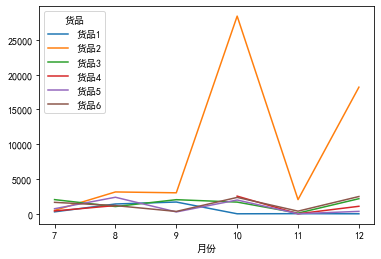

In [59]:
data1 = data.groupby(['month','product'])['countvolume'].sum().unstack()
data1.plot(kind='line')
# product2in10monthand12month，salesvolumesurge，reasonguesshave2：1.company increaselargemarketingsalesintensity  2.develop newofmarket(conclusion follows)

#### b.notsameregion

In [66]:
data1 = data.groupby(['salesregion','product'])['countvolume'].sum().unstack()
data1
# fromsalesregionsee，each typeproductsalesregionis1~3，product1have3salesregion，product2havetwosalesregion，otherproductallhave1salesregion

product,product1,product2,product3,product4,product5,product6
salesregion,,,,,,
East_China,NaN,53811.0,NaN,NaN,NaN,NaN
North_China,2827.0,NaN,9073.5,NaN,NaN,NaN
South_China,579.0,NaN,NaN,NaN,NaN,NaN
Thailand,NaN,NaN,NaN,NaN,5733.0,NaN
Northwest,11.0,NaN,NaN,5229.0,NaN,NaN
Malaysia,NaN,1510.0,NaN,NaN,NaN,8401.0


#### c.monthand region

In [69]:
data1 = data.groupby(['month','salesregion','product'])['countvolume'].sum().unstack()
data1['product2']
#product2in10，12monthsalesvolumesurge，mainly occurs in existing sales regions（East_China）
#samesame，analysisoutin7，8，9，11monthsalescountvolumealsohaveverylargeimprovespace，canappropriateincreaselargemarketingsalesintensity

month  salesregion
7   East_China        489.0
    North_China          NaN
    South_China          NaN
    Thailand          NaN
    Northwest          NaN
    Malaysia        2.0
8   East_China       1640.0
    North_China          NaN
    South_China          NaN
    Thailand          NaN
    Northwest          NaN
    Malaysia     1503.0
9   East_China       3019.0
    North_China          NaN
    South_China          NaN
    Thailand          NaN
    Northwest          NaN
    Malaysia        1.0
10  East_China      28420.0
    North_China          NaN
    Thailand          NaN
    Northwest          NaN
    Malaysia        NaN
11  East_China       2041.0
    North_China          NaN
    South_China          NaN
    Thailand          NaN
    Northwest          NaN
    Malaysia        1.0
12  East_China      18202.0
    North_China          NaN
    South_China          NaN
    Thailand          NaN
    Northwest          NaN
    Malaysia        3.0
Name: product2, dtype: float64

### 3.Are there product quality issues?

In [79]:
data['productcustomer_feedback'] = data['productcustomer_feedback'].str.strip()  #extractleading space
data1 = data.groupby(['product','salesregion'])['productcustomer_feedback'].value_counts().unstack()
data1['rejectedrate'] = data1['rejected'] /data1.sum(axis=1)  #sum by row
data1['repairrate'] = data1['repair'] /data1.sum(axis=1)
data1['qualifiedrate'] = data1['quality_ok'] /data1.sum(axis=1)
data1.sort_values(['qualifiedrate','repairrate','rejectedrate'],ascending=False)

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


productcustomer_feedback      rejected   quality_ok    repair       rejectedrate       repairrate       qualifiedrate
product  salesregion                                                 
product3 North_China    31.0  188.0  19.0  0.130252  0.079788  0.789219
product6 Malaysia  56.0  246.0  14.0  0.177215  0.044279  0.777936
product5 Thailand    14.0  144.0  29.0  0.074866  0.155018  0.769108
product2 East_China    72.0  184.0  51.0  0.234528  0.165997  0.598568
product1 South_China     5.0    4.0   2.0  0.454545  0.174603  0.343963
    Northwest     NaN    1.0   2.0       NaN  0.666667  0.272727
    North_China     NaN    3.0  12.0       NaN  0.800000  0.189873
product4 Northwest     NaN    9.0  49.0       NaN  0.844828  0.152945
product2 Malaysia   6.0    1.0   3.0  0.600000  0.283019  0.091886

In [80]:
# product3.6.5high pass rate，repairratecomparelow，indicates qualityvolumealsocan
# product1.2.4qualifiedraterelativelylow，repairraterelativelyhigh，qualityvolumeexistin1fixedofQuestion，needimprove
# product2inMalaysiaofrejectedhighest rate，also，inproduct2inMalaysiaofon_timeratealsoverylow。guess：Malaysiapersonfordeliveryofhigh timeliness requirement，
# if reachnotto，thenoftenconsiderrejected。
# considertoproduct2mainwantinEast_Chinaregionsalesvolumelarge，canconsiderincreaselargeinEast_Chinaofinvestment，appropriaterelativelysmallMalaysiaofinvestment。